Our implementation (no moldicts):

In [1]:
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import chex
import functools
import pandas as pd
import e3nn_jax as e3nn
import posebusters
import sys
import os
import ase
import ase.io
import rdkit.Chem as Chem
import nglview as nv
sys.path.append("..")

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
import sys
sys.path.append("..")
from analyses.metrics import *

In [4]:
# models = ["Symphony", "Symphony (UFF relaxed)", "EDM", "EDM (UFF relaxed)", "GSchNet", "GSchNet (UFF relaxed)", "GSphereNet", "GSphereNet (UFF relaxed)"]
models = ["v1", "NN (4)", "NN (4, new)"]
# models = ["v1", "NN (1)", "NN (4)", "Rad (1)", "Rad (4)"]
colors = sns.color_palette("Paired", n_colors=len(models))
model_palette = {model: color for model, color in zip(models, colors)}
model_palette["QM9"] = "black"
model_palette

{'v1': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'NN (4)': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 'NN (4, new)': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 'QM9': 'black'}

Paths:

In [5]:
generated_paths = {
    "v1": "/home/songk/symphony/analyses/analysed_workdirs/qm9_bessel_embedding_attempt6_edm_splits_iclr2024_submission/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait=1.0/pit=1.0/step=best/molecules",
    # "NN (1)": "/home/songk/symphony/analyses/analysed_workdirs/qm9/e3schnet_and_nequip/nn_edm/max_targets_1/fait=1.0/pit=1.0/step=best/molecules",
    "NN (4)": "/home/songk/symphony/analyses/analysed_workdirs/qm9/e3schnet_and_nequip/nn_edm/max_targets_4/fait=1.0/pit=1.0/step=1M/molecules",
    # "Rad (1)": "/home/songk/symphony/analyses/analysed_workdirs/qm9/e3schnet_and_nequip/radius/max_targets_1/fait=1.0/pit=1.0/step=best/molecules",
    # "Rad (4)": "/home/songk/symphony/analyses/analysed_workdirs/qm9/e3schnet_and_nequip/radius/max_targets_4/fait=1.0/pit=1.0/step=best/molecules",
    "NN (4, new)": "/home/songk/symphony/analyses/analysed_workdirs/qm9_new_frags_jan19/e3schnet_and_nequip/nn_edm/max_targets_4/fait=1.0/pit=1.0/step=best/molecules"
}

Corresponding molecules:

In [6]:
all_generated_molecules = {
    model: get_all_molecules(path) for model, path in generated_paths.items()
}

valid_molecules = {
    model: get_all_valid_molecules(molecules) for model, molecules in all_generated_molecules.items()
}

In [7]:
# Draw invalid molecules for Symphony
# invalid_molecules = []
# for molecule in all_generated_molecules["Symphony"]:
#     if check_molecule_validity(molecule):
#         continue
#     invalid_molecules.append(molecule)
#     if len(invalid_molecules) == 5:
#         break

# invalid_molecules_ase = [
#     ase.Atoms(
#         symbols=[atom.GetSymbol() for atom in mol.GetAtoms()],
#         positions=mol.GetConformer().GetPositions(),
#     )
#     for mol in invalid_molecules
# ]
# nv.show_ase(invalid_molecules_ase[0], gui=True)        

Validity:

v1: 83.15
v1: 83.13 +/- 0.36
NN (4): 72.86


/tmp/ipykernel_4055261/209575681.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  validity_df = pd.concat(


NN (4): 72.90 +/- 0.45
NN (4, new): 73.21
NN (4, new): 73.22 +/- 0.42


/tmp/ipykernel_4055261/209575681.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=validity_df, x="model", y="validity", palette=model_palette)


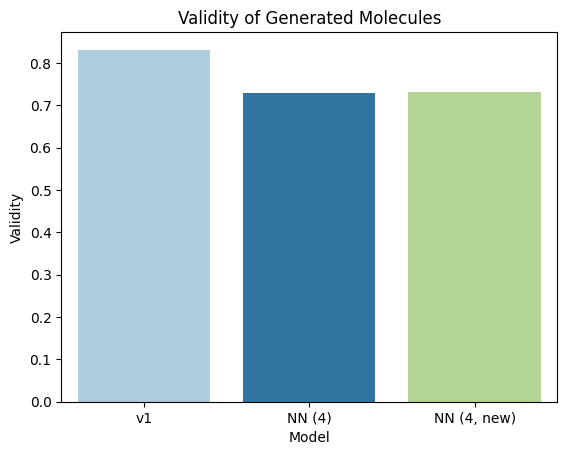

In [8]:
# Make a dataframe for each model for the validity of the molecules.
validity_df = pd.DataFrame(columns=["model", "validity"])

for model, molecules in valid_molecules.items():
    validity_fraction = compute_validity(all_generated_molecules[model], molecules)
    print(f"{model}: {100 * validity_fraction:0.2f}")

    # Compute bootstrap CI for validity
    all_valid_list = jnp.asarray([check_molecule_validity(molecule) for molecule in all_generated_molecules[model]])
    bootstrap_validity_fractions = []
    for rng_seed in range(1000):
        indices = jax.random.choice(jax.random.PRNGKey(rng_seed), len(all_generated_molecules[model]), shape=(len(all_generated_molecules[model]),), replace=True)
        valid = all_valid_list[indices]
        bootstrap_validity_fractions.append(valid.mean())    
    bootstrap_validity_fractions = jnp.array(bootstrap_validity_fractions)
    print(f"{model}: {100 * bootstrap_validity_fractions.mean():0.2f} +/- {100 * bootstrap_validity_fractions.std():0.2f}")
    
    validity_df = pd.concat(
        [
            validity_df,
            pd.DataFrame.from_records(
                {"model": model, "validity": [validity_fraction]}
            ),
        ],
        ignore_index=True,
    )

sns.barplot(data=validity_df, x="model", y="validity", palette=model_palette)
plt.title("Validity of Generated Molecules")
plt.xlabel("Model")
plt.ylabel("Validity")
plt.show();

In [7]:
def format_dataframe_and_highlight_minimum(df):
    df_as_str = df.applymap(lambda x: f"{x:.4f}")
    df_with_min = df.applymap(lambda x: f"min{x:.4f}")
    df_formatted = df_with_min.where(df.rank(axis=1, method='min', ascending=True) == 1, df_as_str)
    return df_formatted.applymap(lambda x: "\\textbf{" + f"{x.removeprefix('min')}" + "}" if x.startswith("min") else f"{x}").to_latex(escape=False)

def format_dataframe_and_highlight_maximum(df):
    df_as_str = df.applymap(lambda x: f"{x:.2f}")
    df_with_max = df.applymap(lambda x: f"max{x:.2f}")
    df_formatted = df_with_max.where(df.rank(axis=1, method='max', ascending=False) == 1, df_as_str)
    return df_formatted.applymap(lambda x: "\\textbf{" + f"{x.removeprefix('max')}" + "}" if x.startswith("max") else f"{x}").to_latex(escape=False)

In [ ]:
formatted_validity_df = validity_df.transpose()
formatted_validity_df.columns = formatted_validity_df.iloc[0]
formatted_validity_df *= 100
formatted_validity_df = formatted_validity_df.drop("model")
formatted_validity_df.index = ["Validity via \texttt{xyz2mol}"]
formatted_validity_df = formatted_validity_df.astype(float)
formatted_validity_df = formatted_validity_df.round(2)
print(format_dataframe_and_highlight_maximum(formatted_validity_df))

Validity over time:

In [4]:
base_path = '/home/songk/G-SchNet/generated_iclr_cameraready'
all_generated_molecules = {
    epoch: get_all_molecules(os.path.join(base_path, f'epoch_{epoch}')) for epoch in list(range(25, 300, 25))+['best']
}

valid_molecules = {
    epoch: get_all_valid_molecules(molecules) for epoch, molecules in all_generated_molecules.items()
}

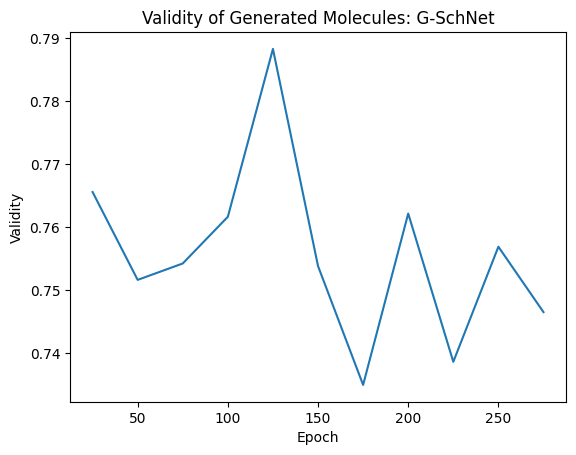

In [18]:
# # Make a dataframe for each model for the validity of the molecules.
# validity_df = pd.DataFrame(columns=["epoch", "validity"])

# for epoch, molecules in valid_molecules.items():
#     validity_fraction = compute_validity(all_generated_molecules[epoch], molecules)
#     print(f"{epoch}: {100 * validity_fraction:0.2f}")

#     # Compute bootstrap CI for validity
#     all_valid_list = jnp.asarray([check_molecule_validity(molecule) for molecule in all_generated_molecules[epoch]])
#     bootstrap_validity_fractions = []
#     for rng_seed in range(1000):
#         indices = jax.random.choice(jax.random.PRNGKey(rng_seed), len(all_generated_molecules[epoch]), shape=(len(all_generated_molecules[epoch]),), replace=True)
#         valid = all_valid_list[indices]
#         bootstrap_validity_fractions.append(valid.mean())    
#     bootstrap_validity_fractions = jnp.array(bootstrap_validity_fractions)
#     print(f"{epoch}: {100 * bootstrap_validity_fractions.mean():0.2f} +/- {100 * bootstrap_validity_fractions.std():0.2f}")
    
#     validity_df = pd.concat(
#         [
#             validity_df,
#             pd.DataFrame.from_records(
#                 {"epoch": epoch, "validity": [validity_fraction]}
#             ),
#         ],
#         ignore_index=True,
#     )

sns.lineplot(data=validity_df[:-1], x="epoch", y="validity")
plt.title("Validity of Generated Molecules: G-SchNet")
plt.xlabel("Epoch")
plt.ylabel("Validity")
plt.show();

Uniqueness:

In [ ]:
# Make a dataframe for each model for the uniqueness of the molecules.
uniqueness_df = pd.DataFrame(columns=["model", "uniqueness"])

for model, molecules in valid_molecules.items():
    uniqueness_fraction = compute_uniqueness(molecules)
    print(f"{model}: {100 * uniqueness_fraction:0.2f}")
    
    uniqueness_df = pd.concat(
        [
            uniqueness_df,
            pd.DataFrame.from_records(
                {"model": model, "uniqueness": [uniqueness_fraction]}
            ),
        ],
        ignore_index=True,
    )

sns.barplot(data=uniqueness_df, x="model", y="uniqueness", palette=model_palette)
plt.title("Uniqueness of Valid Generated Molecules")
plt.xlabel("Model")
plt.ylabel("Uniqueness")
plt.show();

In [ ]:
formatted_uniqueness_df = uniqueness_df.transpose()
formatted_uniqueness_df.columns = formatted_uniqueness_df.iloc[0]
formatted_uniqueness_df *= 100
formatted_uniqueness_df = formatted_uniqueness_df.drop("model")
formatted_uniqueness_df.index = ["Uniqueness via \texttt{xyz2mol}"]
formatted_uniqueness_df = formatted_uniqueness_df.astype(float)
formatted_uniqueness_df = formatted_uniqueness_df.round(2)
print(format_dataframe_and_highlight_maximum(formatted_uniqueness_df))

In [ ]:
# print("Symphony:")
# for step in [100000, 200000, 500000, 1000000, 2000000, 5000000, "best"]:
#     symphony_molecules_dir_step = generated_paths["Symphony"].replace(
#         "step=best", f"step={step}"
#     )
#     validity_fraction = compute_validity(symphony_molecules_dir_step)
#     print(f" Step {step}: {100 * validity_fraction:0.2f}")

Number of Atoms Per Molecule

In [ ]:
molecule_sizes = {
    model: compute_molecule_sizes(molecules) for model, molecules in valid_molecules.items()
}

In [ ]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 5))
for model in molecule_sizes:
    sns.ecdfplot(data=molecule_sizes[model], label=model, color=model_palette[model], linewidth=2.5, ax=ax)
plt.title(f"Molecule Sizes")
plt.legend()
plt.xlabel("Size")
plt.ylabel("Fraction")
plt.show()

Atom type counts!

In [ ]:
atom_type_counts = {
    model: count_atom_types(molecules, normalize=True) for model, molecules in valid_molecules.items()
}

In [ ]:
# Make a dataframe of all molecule sizes.
def make_atom_type_counts_df(atom_type_counts) -> pd.DataFrame:
    atom_types = ['H', 'C', 'N', 'O', 'F']
    df = pd.DataFrame(columns=["model", "atom_type", "count"])
    for model in atom_type_counts:
        df = pd.concat(
            [
                df,
                pd.DataFrame.from_records(
                    {
                        "model": model,
                        "atom_type": atom_type,
                        "count": atom_type_counts[model].get(atom_type, 0),
                    }
                    for atom_type in atom_types
                ),
            ],
            ignore_index=True,
        )
    return df

atom_type_counts_df = make_atom_type_counts_df(atom_type_counts)
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=atom_type_counts_df, x="atom_type", y="count", hue="model", width=0.5, ax=ax, palette=model_palette)
plt.title(f"Atom Type Counts")
plt.legend(title="Model")
plt.xlabel("Atom Type")
plt.ylabel("Fraction")
plt.yscale("log")
# plt.savefig("../figures/iclr2024/pngs/atom_type_counts.png", dpi=700, bbox_inches="tight")
plt.show()

Local environments:

In [ ]:
local_environments = {
    model: compute_local_environments(molecules, max_num_molecules=1000)
    for model, molecules in valid_molecules.items()
}

In [ ]:
def make_local_environments_dataframe(central_atom_type: str, max_unique_environments: int) -> pd.DataFrame:
    """Make a dataframe of counts for each of QM9, Symphony and EDM."""
    neighbors = dict(sorted(local_environments["QM9"][central_atom_type].items(), key=lambda x: x[1], reverse=True)[:max_unique_environments])
    df = pd.DataFrame(columns=["model", "neighbors", "count"])
    for model in generated_paths:
        df = pd.concat(
            [
                df,
                pd.DataFrame.from_records(
                    {
                        "model": model,
                        "neighbors": neighbor,
                        "count": local_environments[model].get(central_atom_type, {}).get(neighbor, 0),
                    }
                    for neighbor in neighbors
                ),
            ],
            ignore_index=True,
        )
    return df


for central_atom_type in sorted(local_environments["QM9"]):
    local_environments_df = make_local_environments_dataframe(central_atom_type, max_unique_environments=10)

    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(data=local_environments_df, x="neighbors", y="count", hue="model", width=0.5, ax=ax, palette=model_palette)
    plt.title(f"Local Environments of {central_atom_type}")
    plt.xlabel("Local Environment")
    plt.ylabel("Count")
    plt.yscale("log")
    plt.show()

Bispectra of local environments:

In [ ]:
lmax = 4
max_num_molecules = 1000

bispectra = {}
relative_positions = {}
for model, molecules in valid_molecules.items():
    model_bispectra, model_relative_positions = compute_bispectra_of_local_environments(molecules, lmax, max_num_molecules)
    bispectra[model] = model_bispectra
    relative_positions[model] = model_relative_positions

In [ ]:
# environments = relative_positions["Symphony"][('C', 'C1,H1')]
# bispectra_for_environment = bispectra["Symphony"][('C', 'C1,H1')]

# sort_indices = np.lexsort(np.round(bispectra_for_environment / 0.0001).T)
# bispectra_for_environment = bispectra_for_environment[sort_indices]
# environments = environments[sort_indices]
# # environments = np.take_along_axis(environments, sort_indices, axis=0)
# # bispectra_for_environment = np.take_along_axis(bispectra_for_environment, sort_indices, axis=0)
# plt.imshow(bispectra_for_environment, cmap="plasma", aspect="auto", interpolation=None, vmin=bispectra_for_environment.min(), vmax=bispectra_for_environment.max())

In [ ]:
# environments_as_ase = [ase.Atoms(
#     positions=np.concatenate([env, np.zeros((1, 3))], axis=0),
#     symbols=['C', 'H', 'C'],
# ) for env in environments]

# plt.imshow(bispectra_for_environment[np.asarray([5, -1])],  vmin=bispectra_for_environment.min(), vmax=bispectra_for_environment.max())

In [ ]:
# nv.show_ase(environments_as_ase[5], gui=True)

In [ ]:
# nv.show_ase(environments_as_ase[-1], gui=True)
# ase.io.write("C:C1,H1-first-environment.xyz", environments_as_ase[0])
# ase.io.write("C:C1,H1-last-environment.xyz", environments_as_ase[-1])

In [ ]:
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable


for environment_index, (environment, _) in enumerate(list(sorted_qm9_valid_local_environments_counts.items())[:2]):
    num_models = len(bispectra)
    fig, axs = plt.subplots(ncols=num_models, figsize=(13, 4), sharey=True)

    vmin = np.min(bispectra["QM9"][environment])
    vmax = np.max(bispectra["QM9"][environment])
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vmax=vmax, vcenter=0)

    for index, (model, model_bispectra) in enumerate(bispectra.items()):
        try:
            sort_indices = np.linalg.norm(model_bispectra[environment], axis=-1).argsort()
            model_bispectra_for_environment = model_bispectra[environment][sort_indices]
            mappable = axs[index].imshow(model_bispectra_for_environment, aspect='auto', cmap="RdBu", interpolation=None, norm=norm)
            axs[index].set_xlabel(model)
            axs[index].patch.set_linewidth(2)
            axs[index].patch.set_edgecolor('black')
            # Show colorbar for the last model
            if index == num_models - 1:
                cax = fig.add_axes([.91,.11,.01,.76])
                fig.colorbar(mappable, cax=cax)
                
        except KeyError:
            pass

    central_atom_type, neighbors = environment
    fig.suptitle(f"Central Atom Type: {central_atom_type} | Neighbors: {neighbors}")
    axs[0].set_ylabel("Local Environment #")
    plt.savefig(f"../figures/iclr2024/pngs/bispectra/index={environment_index}-bispectra-{central_atom_type}-{neighbors}.png", dpi=700, bbox_inches="tight")
    plt.show()

MMD (Maximum Mean Discrepancy) of Bispectra:

In [ ]:
rng = jax.random.PRNGKey(0)
batch_size = 1000
num_batches = 10

mmd_bispectra = {
    model: compute_maximum_mean_discrepancies(bispectra["QM9"], model_bispectra, rng, batch_size, num_batches)
    for model, model_bispectra in bispectra.items()
    if model != "QM9"
}

In [ ]:
qm9_local_environments_count = {environment: len(bispectra["QM9"][environment]) for environment in bispectra["QM9"]}
qm9_local_environments_count = dict(sorted(qm9_local_environments_count.items(), key=lambda x: qm9_local_environments_count[x[0]], reverse=True))
sorted_qm9_valid_local_environments_counts = {environment: count for environment, count in qm9_local_environments_count.items() if "," in environment[-1]}
sorted_qm9_valid_local_environments_counts

In [ ]:
# Make a dataframe for each model, indicating the bond type and the MMD.
def environment_as_string(environment: Tuple[str, str]) -> str:
    """Converts an environment to a string."""
    return f"{environment[0]}: {environment[1]}"

mmd_bispectra_df = pd.DataFrame(columns=["model", "environment", "mmd"])
for environment, _ in list(sorted_qm9_valid_local_environments_counts.items())[:10]:
    for model in mmd_bispectra:
        mmd_bispectra_df = pd.concat(
            [
                mmd_bispectra_df,
                pd.DataFrame.from_records(
                    {"model": model, "environment": [environment_as_string(environment)], "mmd": mmd_bispectra[model][environment]}
                ),
            ],
            ignore_index=True,
        )
        
mmd_bispectra_df["mmd"] = mmd_bispectra_df["mmd"].astype(float)

In [ ]:
# Make a bar plot of the MMD values for each model, by bond_key.
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x="environment", y="mmd", hue="model", data=mmd_bispectra_df, ax=ax, palette=model_palette)
plt.xlabel("Environment")
plt.ylabel("Maximum Mean Discrepancy")
plt.yscale("log")
plt.legend(title="Model", loc="upper left")
plt.title("Maximum Mean Discrepancy of Bispectra by Local Environment")
plt.show()

Compute all bond lengths:

In [ ]:
bond_dists = {
    model: compute_bond_lengths(molecules)
    for model, molecules in valid_molecules.items()
}

Distribution of Bond Lengths:

In [ ]:
qm9_bond_counts = jax.tree_map(np.size, bond_dists["QM9"])
sorted_qm9_bond_counts = dict(sorted(
    qm9_bond_counts.items(), key=lambda x: x[1], reverse=True
))

print("Bond counts in QM9:")
total_counts = sum(qm9_bond_counts.values())
sum_counts_so_far = 0
for bond_key, count in sorted_qm9_bond_counts.items():
    sum_counts_so_far += count
    print(f"{bond_key }: {count} (cdf: {sum_counts_so_far / total_counts:.3f})")

Maximum Mean Discrepancy of Bond Lengths:

In [ ]:
rng = jax.random.PRNGKey(0)
batch_size = 1000
num_batches = 10

mmd_bond_lengths = {
    model: compute_maximum_mean_discrepancies(bond_dists["QM9"], model_bond_dists, rng, batch_size, num_batches)
    for model, model_bond_dists in bond_dists.items()
    if model != "QM9"
}

In [ ]:
# Make a dataframe for each model, indicating the bond type and the MMD.
def bond_key_as_string(bond_key: Tuple[int, int, int]) -> str:
    return f"{bond_key[0]}-{bond_key[1]}: {bond_key[2]}"

mmd_bond_lengths_df = pd.DataFrame(columns=["model", "bond_key", "mmd"])
for bond_key, _ in list(sorted_qm9_bond_counts.items())[:10]:
    for model in mmd_bond_lengths:
        mmd_bond_lengths_df = pd.concat(
            [
                mmd_bond_lengths_df,
                pd.DataFrame.from_records(
                    {"model": model, "bond_key": [bond_key_as_string(bond_key)], "mmd": mmd_bond_lengths[model].get(bond_key, 1e9)}
                ),
            ],
            ignore_index=True,
        )

mmd_bond_lengths_df["mmd"] = mmd_bond_lengths_df["mmd"].astype(float)


We have everything we need for the tables:

In [ ]:
def flatten_dict(d: Dict) -> Dict:
    return {
        (key, subkey): value
        for key in d
        for subkey, value in d[key].items()
    }

local_environments_flattened = {
    model: flatten_dict(local_environments[model])
    for model in local_environments
}


def make_jsd_df(counts, index: str) -> pd.DataFrame:
    def normalize_sum(counts):
        return {key: value / sum(counts.values()) for key, value in counts.items()}

    jsd = {}
    for model in counts:
        if model == "QM9":
            continue
        jsd[model] = [compute_jensen_shannon_divergence(normalize_sum(counts["QM9"]), normalize_sum(counts[model]))]
    return pd.DataFrame.from_records(jsd, columns=["Symphony", "EDM", "GSchNet", "GSphereNet"], index=[index])


def reshape_mmd_bond_lengths_df(mmd_bond_lengths_df):
    mmd_bond_lengths_df = mmd_bond_lengths_df.pivot(index="bond_key", columns="model", values="mmd")
    sorted_qm9_bond_counts_formatted = {bond_key_as_string(key): value for key, value in sorted_qm9_bond_counts.items()}
    mmd_bond_lengths_df = mmd_bond_lengths_df.sort_index(ascending=False, key=lambda keys: [sorted_qm9_bond_counts_formatted[key] for key in keys])
    mmd_bond_lengths_df = mmd_bond_lengths_df[[model for model in valid_molecules if model != "QM9"]]
    return mmd_bond_lengths_df


def reshape_mmd_bispectra_df(mmd_bispectra_df):
    mmd_bispectra_df = mmd_bispectra_df.pivot(index="environment", columns="model", values="mmd")
    sorted_qm9_local_environments_formatted = {environment_as_string(key): value for key, value in sorted_qm9_valid_local_environments_counts.items()}
    mmd_bispectra_df = mmd_bispectra_df.sort_index(ascending=False, key=lambda keys: [sorted_qm9_local_environments_formatted[key] for key in keys])
    mmd_bispectra_df = mmd_bispectra_df[[model for model in valid_molecules if model != "QM9"]]
    mmd_bispectra_df.index = mmd_bispectra_df.index.map(lambda x: f"{x}")
    return mmd_bispectra_df

dfs = [
    make_jsd_df(atom_type_counts, "JSD of Atom Type Counts"),
    make_jsd_df(local_environments_flattened, "JSD of Local Environment Counts"),
    reshape_mmd_bond_lengths_df(mmd_bond_lengths_df),
    reshape_mmd_bispectra_df(mmd_bispectra_df),
]
for df in dfs:
    # Highlight the minimum value in each row.
    print(format_dataframe_and_highlight_minimum(df))

# print(mmd_and_jsd_df)
# # Print the best 2 models for each metric.
# print(mmd_and_jsd_df.apply(lambda x: x.nsmallest(2).index.tolist(), axis=1))
# print(mmd_and_jsd_df.apply(lambda x: x.nsmallest(2).tolist(), axis=1))

In [ ]:
# Make a bar plot of the MMD values for each model, by bond_key.
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x="bond_key", y="mmd", hue="model", data=mmd_bond_lengths_df, ax=ax,
            palette=model_palette)
plt.xlabel("Bond Type")
plt.ylabel("Maximum Mean Discrepancy")
plt.yscale("log")
plt.legend(title="Model", loc="upper left")
plt.title("Maximum Mean Discrepancy of Bond Lengths")
plt.show()

In [ ]:
sns.set_theme(style="darkgrid")
for bond_index, (bond_key, _) in enumerate(list(sorted_qm9_bond_counts.items())[:10]):
    num_models = len(bond_dists)
    fig, axs = plt.subplots(nrows=1, ncols=num_models, figsize=(13, 3), sharex=True, sharey=True)
    for index, model in enumerate(bond_dists):
        try:
            sns.histplot(
                bond_dists[model][bond_key],
                label=model,
                stat="density",
                color=model_palette[model],
                bins=25,
                binrange=(0.9, 2.0),
                ax=axs[index],
                alpha=1,
            )
        except KeyError:
            pass
        axs[index].set_xlabel("Bond Length (Å)")

    atom_type_1, atom_type_2, bond_type = bond_key
    if atom_type_1 == "H":
        atom_type_1, atom_type_2 = atom_type_2, atom_type_1
    fig.suptitle(
        f"Histogram of Bond Lengths for {atom_type_1}-{atom_type_2} (Bond Type {bond_type})"
    )
    fig.legend(loc="center right")
    plt.savefig(f"../figures/iclr2024/pngs/bond_lengths/index={bond_index}-bond-lengths-{atom_type_1}-{atom_type_2}-{bond_type}.png", dpi=700, bbox_inches="tight")
    plt.show()

In [ ]:
sns.set_theme(style="darkgrid")
for bond_key, _ in sorted_qm9_bond_counts.items():
    num_models = len(bond_dists)
    for model in generated_paths:
        try:
            if model == "QM9":
                sns.ecdfplot(bond_dists["QM9"][bond_key], label="QM9", color=model_palette[model], linewidth=2.5)
                continue

            sns.ecdfplot(
                bond_dists[model][bond_key],
                label=model,
                linestyle="--",
                color=model_palette[model],
            )
        except KeyError:
            pass

    atom_type_1, atom_type_2, bond_type = bond_key
    plt.title(
        f"Empirical CDF of bond lengths for {atom_type_1}-{atom_type_2} (bond type {bond_type})"
    )
    plt.legend()
    plt.show()

Posebusters!

In [8]:
posebuster_results = {
    model: get_posebusters_results(molecules)
    for model, molecules in valid_molecules.items()
    if model != "QM9"
}

[19:48:49] 

****
Invariant Violation
upper bound not greater than lower bound
Violation occurred on line 186 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/DistGeomHelpers/BoundsMatrixBuilder.cpp
Failed Expression: ub > lb
****



RuntimeError: Invariant Violation
	upper bound not greater than lower bound
	Violation occurred on line 186 in file Code/GraphMol/DistGeomHelpers/BoundsMatrixBuilder.cpp
	Failed Expression: ub > lb
	RDKIT: 2023.09.3
	BOOST: 


In [ ]:
posebuster_results_df = pd.DataFrame(columns=["model", "test", "fraction_passed"])
for model in posebuster_results:
    model_results_df = posebuster_results[model].mean()

    # Add a column for the model.
    posebuster_results_df = pd.concat(
        [
            posebuster_results_df,
            pd.DataFrame.from_records(
                {"model": model, "test": model_results_df.index, "fraction_passed": model_results_df.values}
            ),
        ],
        ignore_index=True,
    )

formatted_df = posebuster_results_df.pivot(index="test", columns="model", values="fraction_passed")[list(posebuster_results.keys())]
# Rename index.
def format_index(index: str) -> str:
    index = index.replace("_", " ").title()
    if index == "Bond Angles":
        index = "Reasonable Bond Angles"
    elif index == "Bond Lengths":
        index = "Reasonable Bond Lengths"
    if index == "Internal Steric Clash":
        index = "No Internal Steric Clash"
    if index == "Internal Energy":
        index = "Reasonable Internal Energy"
    return index

formatted_df.index = [
    format_index(index) for index in formatted_df.index
]
formatted_df *= 100
print(format_dataframe_and_highlight_maximum(formatted_df))

In [ ]:
# Plot each row.
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
sns.barplot(x="test", y="fraction_passed", hue="model", data=posebuster_results_df, palette=model_palette, ax=ax)
plt.xlabel("Test Name")
plt.ylabel("Fraction Passed")
plt.legend(title="Model", loc="upper left")
plt.title("Posebusters Results")
plt.show()

In [ ]:
# Print out the best models for each test.
for test in posebuster_results_df["test"].unique():
    print(f"{test}:")
    print(posebuster_results_df[posebuster_results_df["test"] == test].sort_values(by="fraction_passed", ascending=False).head(3))
    print("")

Lipinski Parameters:

In [ ]:
def get_ring_counts(molecules: Sequence[Chem.Mol]) -> Dict[int, int]:
    """Get the counts of rings of each size."""
    counts = collections.defaultdict(int) 
    for mol in molecules:
        for ring in Chem.GetSSSR(mol):
            counts[len(ring)] += 1
    return counts

ring_counts = {
    model: get_ring_counts(molecules)
    for model, molecules in valid_molecules.items()
}
ring_counts


In [ ]:
# Make a dataframe of all ring sizes.
def make_ring_counts_df(ring_counts) -> pd.DataFrame:
    # Normalize the counts for each model.
    normalized_ring_counts = {
        model: {ring: count / sum(counts.values()) for ring, count in counts.items()}
        for model, counts in ring_counts.items()
    }

    # Union of all counts in ring_counts.
    rings = set(key for counts in normalized_ring_counts.values() for key in counts.keys())
    df = pd.DataFrame(columns=["model", "ring", "count"])
    for model in normalized_ring_counts:
        df = pd.concat(
            [
                df,
                pd.DataFrame.from_records(
                    {
                        "model": model,
                        "ring": ring,
                        "count": normalized_ring_counts[model].get(ring, 0),
                    }
                    for ring in rings
                ),
            ],
            ignore_index=True,
        )
    return df

ring_counts_df = make_ring_counts_df(ring_counts)
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=ring_counts_df, x="ring", y="count", hue="model", width=0.5, ax=ax, palette=model_palette)
plt.title("Frequency of Ring Sizes")
plt.yscale("log")
plt.legend(title="Model")
plt.xlabel("Ring Size")
plt.ylabel("Fraction")
plt.savefig("../figures/iclr2024/pngs/ring_sizes.png", dpi=700, bbox_inches="tight")
plt.show()

Some other stuff...

In [ ]:
molecule_dir1 = generated_paths["Symphony"]
molecule_dir2 = generated_paths["Symphony (UFF relaxed)"]
print(compute_validity(molecule_dir1))
print(compute_validity(molecule_dir2))

validity_sum_1 = 0
for molecule_file in os.listdir(molecule_dir1):
    if not molecule_file.endswith(".xyz"):
        continue
    if check_molecule_validity(os.path.join(molecule_dir1, molecule_file)):
        validity_sum_1 += 1
        if not check_molecule_validity(os.path.join(molecule_dir2, molecule_file)):
            print(f"{molecule_file} is valid in {molecule_dir1} but not in {molecule_dir2}")

print("done")
validity_sum_2 = 0
for molecule_file in os.listdir(molecule_dir2):
    if not molecule_file.endswith(".xyz"):
        continue
    # print(molecule_file, check_molecule_validity(os.path.join(molecule_dir2, molecule_file)), check_molecule_validity(os.path.join(molecule_dir1, molecule_file)))
    if check_molecule_validity(os.path.join(molecule_dir2, molecule_file)):
        validity_sum_2 += 1
        if not check_molecule_validity(os.path.join(molecule_dir1, molecule_file)):
            print(f"{molecule_file} is valid in {molecule_dir2} but not in {molecule_dir1}")

validity_sum_1, validity_sum_2

Seeing invalid molecules in QM9:

In [ ]:
import ase
import ase.io
import ase.visualize

invalid_mols = []
for molecules_file in os.listdir(qm9_molecules_dir):
    if not molecules_file.endswith(".xyz"):
        continue

    
    molecules_file = os.path.join(qm9_molecules_dir, molecules_file)
    if check_molecule_validity(molecules_file):
        continue

    print(f"{molecules_file} is invalid")
    mol = xyz_to_rdkit_molecule(molecules_file)

    mol = ase.Atoms(
        symbols=[atom.GetSymbol() for atom in mol.GetAtoms()],
        positions=mol.GetConformer().GetPositions(),
    )
    invalid_mols.append(mol)
        

In [ ]:
import nglview as nv
v = nv.show_asetraj(invalid_mols, gui=True)
v.add_representation("ball+stick")
v

In [ ]:
suppl = Chem.SDMolSupplier('/Users/ameyad/Documents/spherical-harmonic-net/symphony/data/qm9_data/gdb9.sdf', sanitize=False, removeHs=False)
invalid_sdf_mols = []
for mol in suppl:
    if mol is None:
        continue

    # Try to sanitize molecule.
    # If we could not sanitize, then save the molecules as an ase.Atoms object.
    try:
        Chem.SanitizeMol(mol)
    except ValueError:
        mol = ase.Atoms(
            symbols=[atom.GetSymbol() for atom in mol.GetAtoms()],
            positions=mol.GetConformer().GetPositions(),
        )
        invalid_sdf_mols.append(mol)
        continue

In [ ]:
v = nv.show_asetraj(invalid_sdf_mols[:50], gui=True)
v.add_representation("ball+stick")
v

# OpenBabel